Задача 1: Прогнозування попиту
Мета: Розробити систему прогнозування попиту на
короткостроковий період (14 днів) через 7 днів від останньої дати в
даних, для всіх груп товарів.
Опис:
1. Використовуючи надані дані про транзакції, створіть дві моделі
прогнозування:
 - Модель машинного навчання.
 - Класичну модель прогнозування часових рядів.
2. Дайте обґрунтовані коментарі щодо вибору методів та підходів,
поясніть, чому ви обрали саме їх.
2
3. Надати скрипт або ноутбук (.py/.ipynb), який буде містити
технічне рішення та можливість розрахунку прогнозу на майбутній
період (scoring).
Очікуваний результат: Файл з кодом (.py або .ipynb), який включає
дві моделі прогнозування, пояснення вибору методів, і можливість
розрахунку прогнозу на майбутній період.


In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

**Підготовка даних**

In [143]:
# Завантажимо потрібні дані з CSV файлів

orders = pd.read_csv('S_Data/orders.csv')
order_items = pd.read_csv('S_Data/order_items.csv')


In [144]:
# Дослідимо таблицю orders
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [145]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [146]:
# Переглянемо можливі статуси замовлення
orders['order_status'].value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

In [147]:
# Видалимо замовлення зі статусами "Відмінено" та "Недоступно"

orders = orders[~orders['order_status'].isin(['canceled', 'unavailable'])]
orders['order_status'].value_counts()

order_status
delivered     96478
shipped        1107
invoiced        314
processing      301
created           5
approved          2
Name: count, dtype: int64

In [148]:
# Дослідимо таблицю order_items

order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [149]:
price = order_items['price']
price.describe()

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

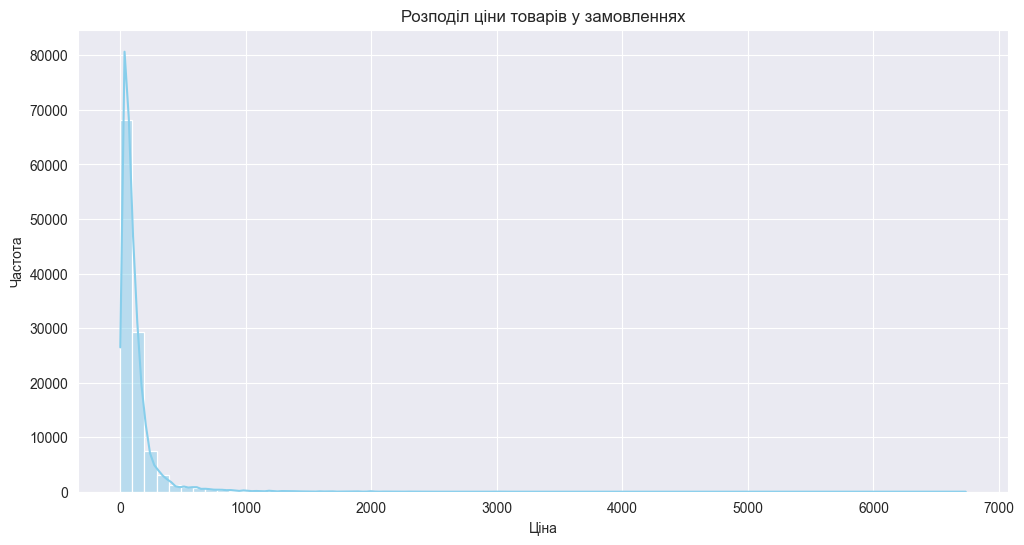

In [150]:
# Візуалізація розподілу ціни

plt.figure(figsize=(12, 6))
sns.histplot(price, bins=70, kde=True, color='skyblue')
plt.title('Розподіл ціни товарів у замовленнях')
plt.xlabel('Ціна')
plt.ylabel('Частота')
plt.show()

In [151]:
# Відсортуємо значення у порядку спадання
price.sort_values(ascending=False)

3556      6735.00
112233    6729.00
107841    6499.00
74336     4799.00
11249     4690.00
           ...   
57300        1.20
57307        1.20
48625        0.85
27652        0.85
87081        0.85
Name: price, Length: 112650, dtype: float64

In [152]:
# Об'єднанаємо  дані в одну таблицю
merged_data = pd.merge(orders, order_items, on='order_id')
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112101 entries, 0 to 112100
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112101 non-null  object 
 1   customer_id                    112101 non-null  object 
 2   order_status                   112101 non-null  object 
 3   order_purchase_timestamp       112101 non-null  object 
 4   order_approved_at              112086 non-null  object 
 5   order_delivered_carrier_date   111380 non-null  object 
 6   order_delivered_customer_date  110189 non-null  object 
 7   order_estimated_delivery_date  112101 non-null  object 
 8   order_item_id                  112101 non-null  int64  
 9   product_id                     112101 non-null  object 
 10  seller_id                      112101 non-null  object 
 11  shipping_limit_date            112101 non-null  object 
 12  price                         

In [153]:
df = merged_data[['order_purchase_timestamp', 'price']]
df

,order_purchase_timestamp,price
0,2017-10-02 10:56:33,29.99
1,2018-07-24 20:41:37,118.70
2,2018-08-08 08:38:49,159.90
3,2017-11-18 19:28:06,45.00
4,2018-02-13 21:18:39,19.90
...,...,...
112096,2018-02-06 12:58:58,174.90
112097,2017-08-27 14:46:43,205.99
112098,2018-01-08 21:28:27,179.99
112099,2018-01-08 21:28:27,179.99


In [154]:
# Перевіримо чи є пропущені значення
print(df.isnull().sum())

order_purchase_timestamp    0
price                       0
dtype: int64


**Прогнозування часових рядів**

In [155]:
# Створюємо часовий ряд
data_ts = df.copy()

data_ts['order_purchase_timestamp'] = pd.to_datetime(data_ts['order_purchase_timestamp'])
data_ts.set_index('order_purchase_timestamp', inplace=True)

In [156]:
data_ts

,price
order_purchase_timestamp,
2017-10-02 10:56:33,29.99
2018-07-24 20:41:37,118.70
2018-08-08 08:38:49,159.90
2017-11-18 19:28:06,45.00
2018-02-13 21:18:39,19.90
...,...
2018-02-06 12:58:58,174.90
2017-08-27 14:46:43,205.99
2018-01-08 21:28:27,179.99


In [157]:
# Згрупуємо продажі по дням
daily_sales = data_ts.resample('D').sum()['price']

In [158]:
daily_sales

order_purchase_timestamp
2016-09-04     72.89
2016-09-05      0.00
2016-09-06      0.00
2016-09-07      0.00
2016-09-08      0.00
               ...  
2018-08-30      0.00
2018-08-31      0.00
2018-09-01      0.00
2018-09-02      0.00
2018-09-03    145.00
Freq: D, Name: price, Length: 730, dtype: float64

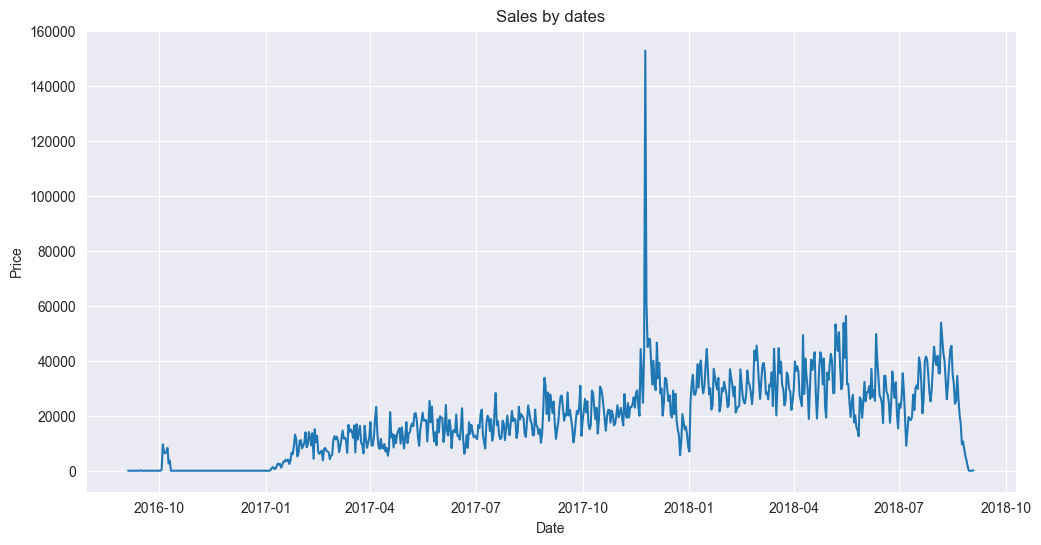

In [160]:
plt.figure(figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Sales by dates')
plt.plot(daily_sales)
plt.show()

In [161]:
# Знаходження викидів

Q1 = daily_sales.quantile(0.25)
Q3 = daily_sales.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = daily_sales[(daily_sales < lower_bound) | (daily_sales > upper_bound)]

print("Кількість викидів:", len(outliers))
print("Викиди:", outliers)

Кількість викидів: 2
Викиди: order_purchase_timestamp
2017-11-24    152653.74
2017-11-25     60923.48
Freq: D, Name: price, dtype: float64


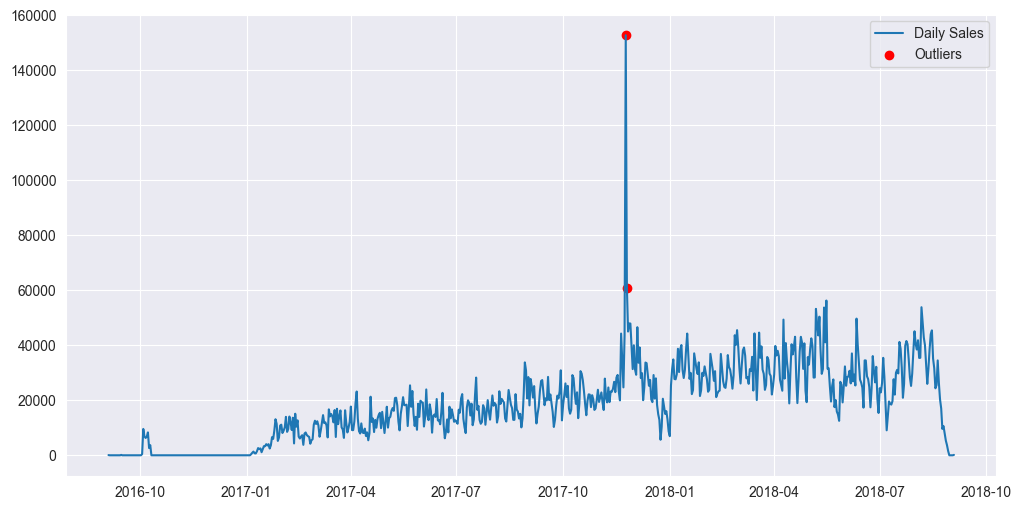

In [162]:
# Візуалізація викидів
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales, label='Daily Sales')
plt.scatter(outliers.index, outliers, color='red', label='Outliers')
plt.legend()
plt.show()

У контексті даної задачі викиди можуть відігравати важливу роль для розуміння ринку, тому було прийнято рішення їх залишити.

**Вибір моделі прогнозування часових рядів**

Для вибору найкращої моделі прогнозування часових рядів, порівняємо такі моделі як ARIMA, SARIMA та Holt-Winters. Для оцінки правильності прогнозу розділимо часовий ряд на тренувальний та тестовий набори. Так як, на даних за останні 14 днів відбувається зміна тренду, на даному етапі видалимо їх та візьмемо за тестовий набір дані за попередні 14 днів. 


In [163]:
# Видалення останніх 14 днів
daily_sales_without_14days = daily_sales[:-14]

# Розділення на тренувальний та тестовий набори
train = daily_sales_without_14days[:-14]
test = daily_sales_without_14days[-14:]

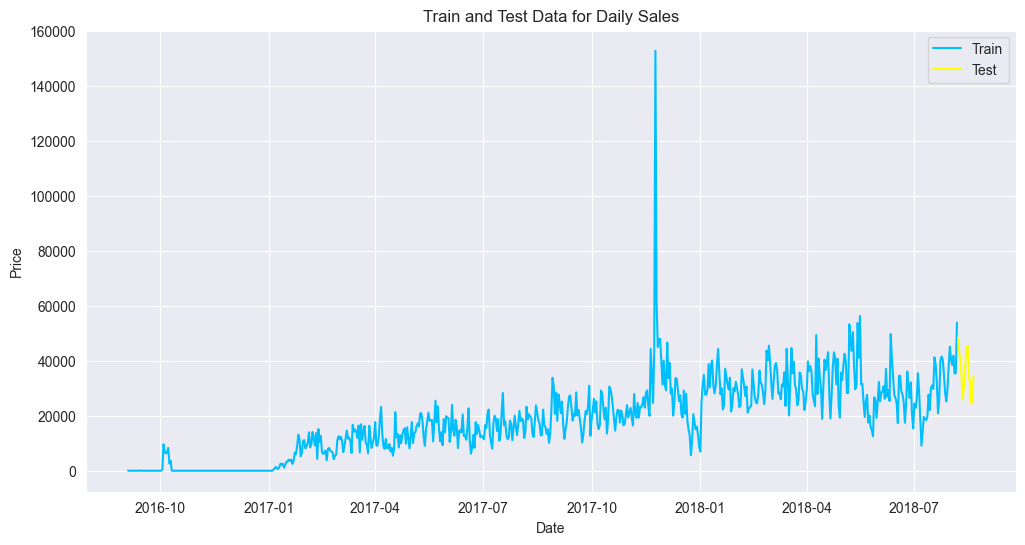

In [164]:
# Візуалізація розділення даних

plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train', color='deepskyblue')
plt.plot(test.index, test, label='Test', color='yellow')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Train and Test Data for Daily Sales')
plt.legend()
plt.show()

ARIMA

In [165]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

# Побудова моделі ARIMA
arima_model = ARIMA(train, order=(5, 1, 0))
arima_fit = arima_model.fit()

# Прогнозування
arima_forecast = arima_fit.forecast(steps=14)

# Обчислення метрик
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_mae = mean_absolute_error(test, arima_forecast)
arima_mape = mean_absolute_percentage_error(test, arima_forecast)


SARIMA (Seasonal ARIMA)

In [166]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Побудова моделі SARIMA
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sarima_fit = sarima_model.fit(disp=False)

# Прогнозування
sarima_forecast = sarima_fit.forecast(steps=14)

# Обчислення метрик
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_mape = mean_absolute_percentage_error(test, sarima_forecast)


Holt-Winters

In [237]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Побудова моделі Holt-Winters
hw_model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=7)
hw_fit = hw_model.fit()

# Прогнозування
hw_forecast = hw_fit.forecast(steps=14)

# Обчислення метрик
hw_rmse = np.sqrt(mean_squared_error(test, hw_forecast))
hw_mae = mean_absolute_error(test, hw_forecast)
hw_mape = mean_absolute_percentage_error(test, hw_forecast)

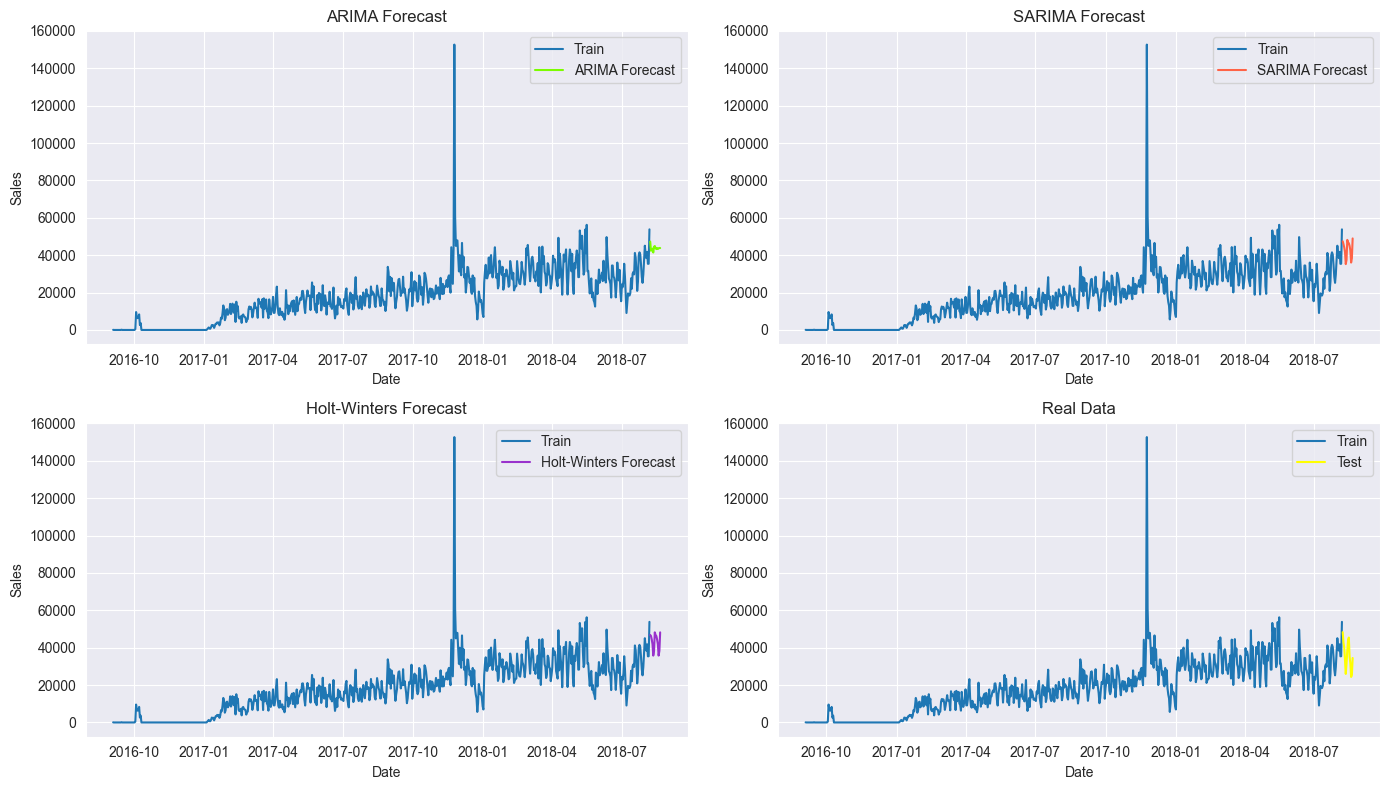

In [168]:
# Візуалізація результатів
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Графік 1: ARIMA
axes[0, 0].plot(train.index, train, label='Train')
axes[0, 0].plot(test.index, arima_forecast, label='ARIMA Forecast', color='lawngreen')
axes[0, 0].legend()
axes[0, 0].set_title('ARIMA Forecast')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Sales')

# Графік 2: SARIMA
axes[0, 1].plot(train.index, train, label='Train')
axes[0, 1].plot(test.index, sarima_forecast, label='SARIMA Forecast', color='tomato')
axes[0, 1].legend()
axes[0, 1].set_title('SARIMA Forecast')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Sales')

# Графік 3: Holt-Winters
axes[1, 0].plot(train.index, train, label='Train')
axes[1, 0].plot(test.index, hw_forecast, label='Holt-Winters Forecast', color='darkorchid')
axes[1, 0].legend()
axes[1, 0].set_title('Holt-Winters Forecast')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Sales')

# Графік 4: Реальні дані (Train + Test)
axes[1, 1].plot(train.index, train, label='Train')
axes[1, 1].plot(test.index, test, label='Test', color='yellow')
axes[1, 1].legend()
axes[1, 1].set_title('Real Data')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Sales')

plt.tight_layout()
plt.show()

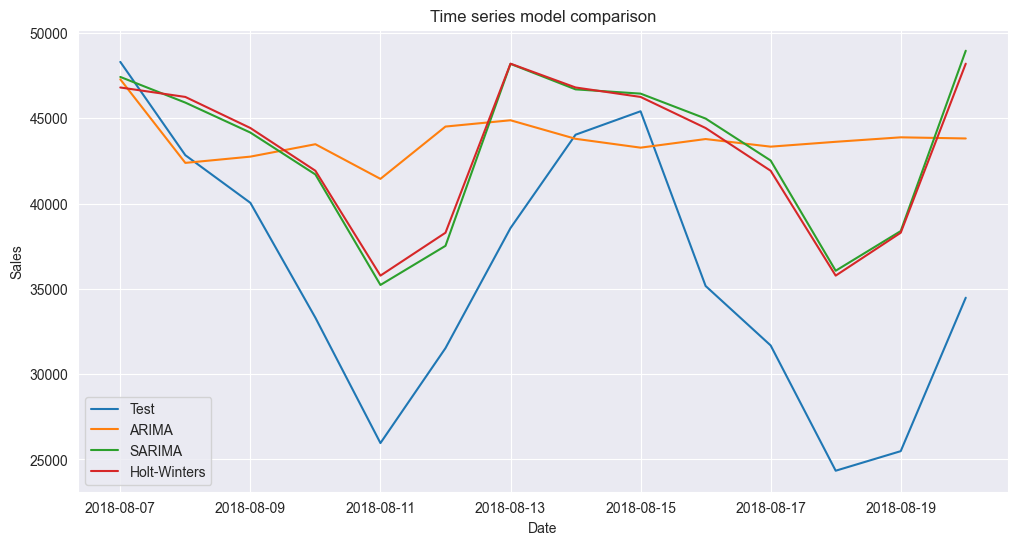

In [169]:
plt.figure(figsize=(12, 6))

plt.title('Time series model comparison')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.plot(test.index, test, label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA')
plt.plot(test.index, sarima_forecast, label='SARIMA')
plt.plot(test.index, hw_forecast, label='Holt-Winters')

plt.legend()
plt.show()

In [231]:
# Подивимось також на метрики
print(pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Holt-Winters'],
    'RMSE': [arima_rmse, sarima_rmse, hw_rmse],
    'MAE': [arima_mae, sarima_mae, hw_mae],
    'MAPE': [arima_mape, sarima_mape, hw_mape]
}))


          Model          RMSE          MAE      MAPE
0         ARIMA  10594.460125  8482.779115  0.287544
1        SARIMA   8647.972951  7484.679236  0.239503
2  Holt-Winters   8844.637778  7795.430825  0.248684


Отже, моделі SARIMA та Holt-Winters, відповідно до метрик та графіків, справилися набагато краще, ніж ARIMA. SARIMA (Seasonal ARIMA) підходить краще до даних, що мають сезонних характер. Так само і Holt-Winters, яка враховує тренд та сезонність. Holt-Winters показала дещо метрики та точніший графік, тому для передбачення використовуватимемо саме її.

**Вибір моделі машинного навчання**

In [182]:
daily_sales_df = daily_sales.reset_index()
daily_sales_df.rename(columns={'order_purchase_timestamp': 'date_of_purchase'}, inplace=True)
daily_sales_df

,date_of_purchase,price
0,2016-09-04,72.89
1,2016-09-05,0.00
2,2016-09-06,0.00
3,2016-09-07,0.00
4,2016-09-08,0.00
...,...,...
725,2018-08-30,0.00
726,2018-08-31,0.00
727,2018-09-01,0.00
728,2018-09-02,0.00


In [183]:
# Розіб'ємо дату на рік, місяць, день

daily_sales_df['year'] = daily_sales_df['date_of_purchase'].apply(lambda x: x.year)
daily_sales_df['month'] = daily_sales_df['date_of_purchase'].apply(lambda x: x.month)
daily_sales_df['day'] = daily_sales_df['date_of_purchase'].apply(lambda x: x.day)

In [184]:
daily_sales_df

,date_of_purchase,price,year,month,day
0,2016-09-04,72.89,2016,9,4
1,2016-09-05,0.00,2016,9,5
2,2016-09-06,0.00,2016,9,6
3,2016-09-07,0.00,2016,9,7
4,2016-09-08,0.00,2016,9,8
...,...,...,...,...,...
725,2018-08-30,0.00,2018,8,30
726,2018-08-31,0.00,2018,8,31
727,2018-09-01,0.00,2018,9,1
728,2018-09-02,0.00,2018,9,2


In [185]:
# Використаємо OneHot кодування дат, що дозволить моделі вивчати зв’язки між датами та цільовою змінною.
from sklearn.preprocessing import OneHotEncoder


encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(daily_sales_df[['year', 'month', 'day']])

In [186]:
encoded_features

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [187]:
daily_sales_df_without_14days = daily_sales_df[:-14]
encoded_features_without_14days = encoded_features[:-14]


In [217]:
X_train = encoded_features_without_14days[:-14]
y_train = daily_sales_df_without_14days[:-14]['price']

X_test = encoded_features_without_14days[-14:]
y_test = daily_sales_df_without_14days[-14:]['price']

In [218]:
X_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [189]:
y_test

702    48298.68
703    42831.07
704    40040.28
705    33305.73
706    25960.93
707    31524.21
708    38561.21
709    44030.95
710    45405.14
711    35166.77
712    31683.18
713    24340.95
714    25487.39
715    34479.50
Name: price, dtype: float64

Random Forest

In [219]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor


# Створення та навчання моделі Random Forest
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

# Прогнозування
y_pred = rf.predict(X_test)

# Оцінка результатів
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

RMSE: 7923.174189505477
MAE: 6744.093865714304
MAPE: 21.356262790779237


In [220]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_forecast = linear_model.predict(X_test)

# Оцінка результатів
rmse = np.sqrt(mean_squared_error(y_test, linear_forecast))
mae = mean_absolute_error(y_test, linear_forecast)
mape = np.mean(np.abs((y_test - linear_forecast) / y_test)) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')


RMSE: 8118.439242171841
MAE: 6944.905
MAPE: 21.89853668795286


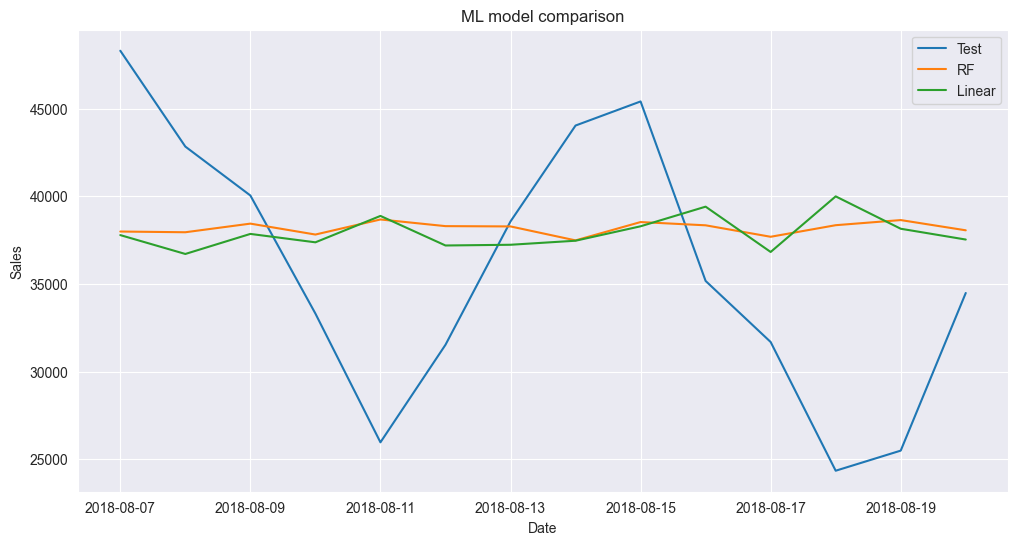

In [221]:
plt.figure(figsize=(12, 6))

plt.title('ML model comparison')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.plot(daily_sales_df['date_of_purchase'][-28:-14], y_test, label='Test')
plt.plot(daily_sales_df['date_of_purchase'][-28:-14], y_pred, label='RF')
plt.plot(daily_sales_df['date_of_purchase'][-28:-14], linear_forecast, label='Linear')

plt.legend()
plt.show()

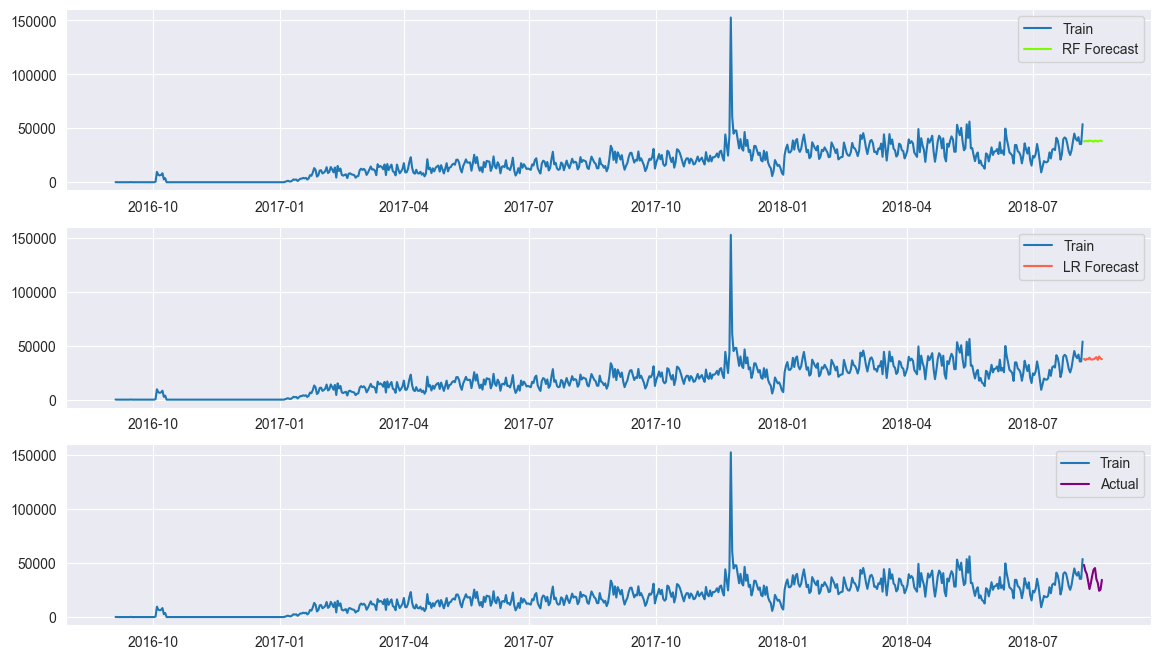

In [225]:
# Візуалізація результатів
fig, axes = plt.subplots(3, 1, figsize=(14, 8))

# Графік 1: ARIMA
axes[0].plot(daily_sales_df['date_of_purchase'][:-28], y_train, label='Train')
axes[0].plot(daily_sales_df['date_of_purchase'][-28:-14], y_pred, label='RF Forecast', color='lawngreen')
axes[0].legend()

# Графік 2: SARIMA
axes[1].plot(daily_sales_df['date_of_purchase'][:-28], y_train, label='Train')
axes[1].plot(daily_sales_df['date_of_purchase'][-28:-14], linear_forecast, label='LR Forecast', color='tomato')
axes[1].legend()

# Графік 2: SARIMA
axes[2].plot(daily_sales_df['date_of_purchase'][:-28], y_train, label='Train')
axes[2].plot(daily_sales_df['date_of_purchase'][-28:-14], y_test, label='Actual', color='purple')
axes[2].legend()


Хоча метрики ML моделей майже такі ж, як у моделей для часових рядів, по графікам видно, що Random Forest та Linear Regression не змогли дати точний прогноз.

**Прогнозування**

Використаємо модель Holt-Winters для прогнозування попиту на 14 днів

In [227]:
daily_sales

order_purchase_timestamp
2016-09-04     72.89
2016-09-05      0.00
2016-09-06      0.00
2016-09-07      0.00
2016-09-08      0.00
               ...  
2018-08-30      0.00
2018-08-31      0.00
2018-09-01      0.00
2018-09-02      0.00
2018-09-03    145.00
Freq: D, Name: price, Length: 730, dtype: float64

In [242]:
hw_model = ExponentialSmoothing(daily_sales, seasonal='add', seasonal_periods=7)
hw_fit = hw_model.fit()

hw_forecast = hw_fit.forecast(steps=14)
hw_forecast = np.maximum(hw_forecast, 0)

In [243]:
hw_forecast

2018-09-04    4293.977511
2018-09-05    3457.676103
2018-09-06    1415.188879
2018-09-07       0.000000
2018-09-08       0.000000
2018-09-09       0.000000
2018-09-10    5611.595097
2018-09-11    4293.977511
2018-09-12    3457.676103
2018-09-13    1415.188879
2018-09-14       0.000000
2018-09-15       0.000000
2018-09-16       0.000000
2018-09-17    5611.595097
Freq: D, dtype: float64

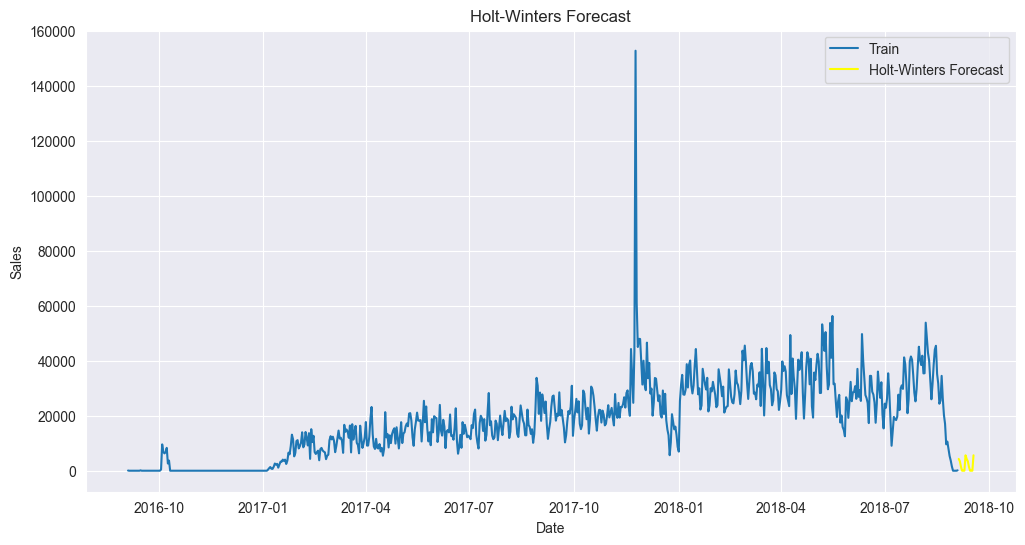

In [244]:
plt.figure(figsize=(12, 6))
plt.title('Holt-Winters Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.plot(daily_sales.index, daily_sales, label='Train')
plt.plot(hw_forecast.index, hw_forecast, label='Holt-Winters Forecast', color='yellow')

plt.legend()
plt.show()